In [11]:
import numpy as np
import pandas as pd
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import OneHotEncoder
from utils import DATA_PATH, aggregate_replicates, WT_LIBRARY_MAP
from ETL import INCLUDED_FEATURES


## Candidate Generation

I generate candidate sequences using the trained model from [Fitness Modeling.ipynb](Fitness Modeling.ipynb). The candidates are generated to satisfy one of three criteria: maximize binding affinitey, maximize distance from the wild-type sequence while maintaining WT-affinity, and to maximize information content of the sequence given known experimental data.

The candidate sequence files are available in `data/`
- i. `max_affinity.parquet` 
- ii. `max_distance.parquet` 
- iii. `max_informatative.parquet` 

The files also contain possibly low-quality 'burn-in' sequences proposed by the first steps of the MCMC process. They can be filtered by `y_hat` (model predicted affinity) as desired.

As my fitness model was only for AAYL49, this section will focus on that chain as well. Future work would be to model and generate for AAY50 as well, as done in [Li et al. 2022](https://www.biorxiv.org/content/10.1101/2022.10.07.502662v1.full.pdf).

## Procedure

To generate top candidates, I follow the [Biswas et al. 2020](https://www.biorxiv.org/content/10.1101/2020.01.23.917682v2.full.pdf) MCMC approach (Metropolis-Hastings).
For this step, I'm actually not going to use the FAIR-ESM2 embedding-based model and instead opt for a one-hot based model. This is simply to save some grunt work and computation of wiring in residue -> embedding translation into the workflow. 

First, I train a model on the full dataset (no test holdout).

In [12]:
# train on the full dataset
LIBRARY = "AAYL49"
# Parameters learned from basic manual hyperparam optimization
model = KernelRidge(alpha=1.0, gamma=0.1)  # type: ignore 
df = pd.read_parquet(f"{DATA_PATH}/{LIBRARY}_expanded.parquet")
df = aggregate_replicates(df, fillna='max')   # type: ignore 
wt_affinity = df.reset_index()[df.reset_index()['POI'] == WT_LIBRARY_MAP[LIBRARY]]["Pred_affinity"].values[0]
feature_cols = df.columns[df.columns.isin(INCLUDED_FEATURES)==False]
features_df = df[feature_cols]
targets = df['Pred_affinity'].values

In [ ]:

enc = OneHotEncoder()
one_hot_df = enc.fit_transform(features_df).todense()
assert one_hot_df.shape[1] == features_df.columns.shape[0] * 20 
features = np.asarray(one_hot_df)
model.fit(X=features, y=targets)

In [3]:
AMINO_ACIDS = ['G', 'L', 'A', 'C', 'E', 'T', 'H', 'N', 'D', 'K', 'I', 'W', 'S', 'P', 'M', 'V', 'R', 'F', 'Y', 'Q']

def mutate_amino_acid(wt_residue: str):
    mutant_aas = [aa for aa in AMINO_ACIDS if aa != wt_residue]
    amino_acid_ix = int(np.round(np.random.randint(0, len(mutant_aas))))
    return mutant_aas[amino_acid_ix]

def one_hot_encode(sequence: pd.Series, enc):
    return enc.transform(pd.DataFrame(sequence).T)

# the library's wild-type sequence
wt_seq = df.loc[WT_LIBRARY_MAP[LIBRARY]][feature_cols]

# the sequence with best affinity as measured by Engelhart
max_affinity_seq = df.sort_values('Pred_affinity').iloc[0][feature_cols]

Then I set up the MCMC with some options to focus it for each sub-task 

In [4]:
ITERS = 3000

# What to optimize
IMPROVEMENT_METRIC = 'affinity' 
# IMPROVEMENT_METRIC = 'distance'

def run_chain(
        chain_index, 
        model=model, 
        enc=enc, 
        iters=ITERS, 
        improvement_metric= IMPROVEMENT_METRIC 
    ):
    print(chain_index)
    np.random.seed(chain_index)
    match improvement_metric:
        case 'affinity':
            # start mutating the best sequence measured by Engelhart
            # TODO: randomize among top sequences instead of using just one
            start_sequence = max_affinity_seq 
        case 'distance':
            start_sequence = wt_seq

    state_sequence = start_sequence  # type: ignore 
    y_hat_start = model.predict(one_hot_encode(state_sequence, enc))
    y_hat_state = y_hat_start
    mu = np.random.uniform(1, 2.5)
    chain_data = []
    TRUST_RADIUS = 10
    TEMP = .1

    for i in range(iters):
        # random select # and indices of places to mutate 
        number_of_mutations = np.random.poisson(mu) + 1
        mutation_indices = np.random.choice(
            range(0, len(state_sequence)), replace=False, size=number_of_mutations
        )
        proposed_state_sequence = state_sequence.copy()
        # create a random mutant
        for index in mutation_indices:
            wt_residue = state_sequence.iloc[index]
            proposed_state_sequence.iloc[index] = mutate_amino_acid(wt_residue)

        mutation_distance_from_wt = (proposed_state_sequence != wt_seq).sum()

        # check mutant isn't too distant from WT
        if mutation_distance_from_wt <= TRUST_RADIUS:
            y_hat_proposed = model.predict(one_hot_encode(proposed_state_sequence, enc))

            match improvement_metric:
                case 'affinity':
                    # improvement metric for minimizing `Pred_affinity`
                    # multiply by negative 1 because higher `Pred_affinity` 
                    # is worse binding
                    improvement = -1 * (y_hat_proposed - y_hat_state)[0]
                case 'distance':
                    epsilon = .5
                    # Improvement metric penalizes distance from WT affinity
                    proposed_distance = np.abs(y_hat_proposed - wt_affinity)[0]
                    if proposed_distance < epsilon:
                        # accept with high likelihood if close to WT
                        improvement = 1 
                    else:
                        # accept more if proposed seq is closer to WT affinity
                        # than current state
                        improvement = (np.abs(y_hat_state - wt_affinity) - proposed_distance)[0]
            prob = np.min([1, np.exp(improvement / TEMP)])  # type: ignore 
            accept: bool = np.random.binomial(1, p=prob)
            if accept:
                # Update current state, save chain history
                state_sequence = proposed_state_sequence
                y_hat_state = y_hat_proposed
                print('current_state', y_hat_state[0])
                columns = ['chain_index', 'i', 'prob', 'y_hat', 'mutation_distance'] + list(state_sequence.index)
                v = [chain_index, i, prob, y_hat_state[0], mutation_distance_from_wt] + list(state_sequence.values)
                s = pd.Series(v, index=columns)
                chain_data.append(s)
    return pd.concat(chain_data, axis=1).T

In [ ]:
# Parallelize MCMC across cpu cores
import multiprocess as mp

pool = mp.Pool(mp.cpu_count())
# Given a different random seed to each chain
results = pool.map(run_chain, range(2, 100))
pool.close()

In [6]:
path = f'{DATA_PATH}/max_{IMPROVEMENT_METRIC}.parquet'

# Either create or append to existing data 
try:
    past_data = pd.read_parquet(path)
    pd.concat([past_data, pd.concat(results)]).to_parquet(path)
except FileNotFoundError:
    pd.concat(results).to_parquet(path)

## Maximize Binding Affinity

I follow Biswas et al. more or less exactly with some parameter modifications. 
- I set a trust radius of 10 (mutants with k > Trust Radius distance from WT are automatically rejected). Biswas used 15 for their GFP work and 7 for beta-lactamase models based on the mutations in their respective training data. I'm going to go with something in between because the Engelhart training data has a mutation count in between those.
-  I found that a slightly higher temp was necessary to get good explore/exploit heuristics (the chain usually exploits but sometimes explores too) 

I generated ~4k sequences using a Boltzmann distribution that seeks to minimize `Pred_affinity`.  I used the highest affinity mutant found by Engelhart as the starting point of chain; future work would be to use a variety of promising mutants for different chains.

I only generate a few thousand candidates for now, as the MCMC process is computationally expensive. Further work would be to either deploy into a large cloud instance or look into more efficient MCMC algorithms (Metropolis-Hastings is simple to use and understand, but also known to be quite inefficient. Hamiltonian MCMC algorithms could be a good replacement.)

Finally I filter out any 'burn-in' sequences with a low predicted affinity for a final proposed set of ~1400 candidates.

Candidate count  1381


Text(0.5, 0, 'Predicted `Pred_affinity`')

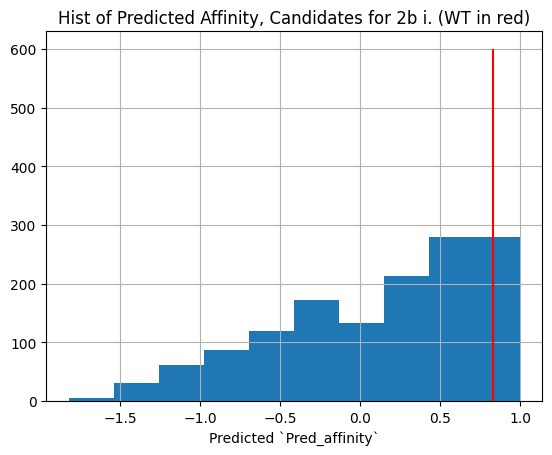

In [7]:
path = f'{DATA_PATH}/max_affinity.parquet'
bi_seqs = pd.read_parquet(path).drop_duplicates()
# Filter out "burn in" sequence with poor predicted affinity
bi_seqs = bi_seqs[bi_seqs['y_hat'] < 1.0]['y_hat']
print("Candidate count:", bi_seqs.shape[0])
ax = bi_seqs.hist()
ax.vlines(wt_affinity, ymax=600, ymin=0, color='red')  # type: ignore 
ax.set_title('Hist of Predicted Affinity, Candidates: Maximize Binding Affinity. (WT in red)')
ax.set_xlabel("Predicted `Pred_affinity`")

## Maximize Distance from WT while Maintaining WT Affinity

Here, I modified the Boltzmann distribution to penalize distance from WT affinity beyond some epsilon = 0.5, using the WT sequence  as the starting point of the chain. Even though the mandate is to maximize sequence diversity, I still keep the trust radius of 10 in place, because it's doubtful that the model's predictions will be very meaningful beyond some reasonable limit. Future work would be to quantify the model's accuracy w.r.t. mutational distance.

Note that this approach doesn't actively push the candidate search to maximize mutational distance. However the MCMC process tends to naturally wander far from the seed, and most of the proposed sequences are k=10 (the limit of the trust radius) away from WT (see second hist below)

Candidate count:  1011


Text(0.5, 0, 'Predicted `Pred_affinity`')

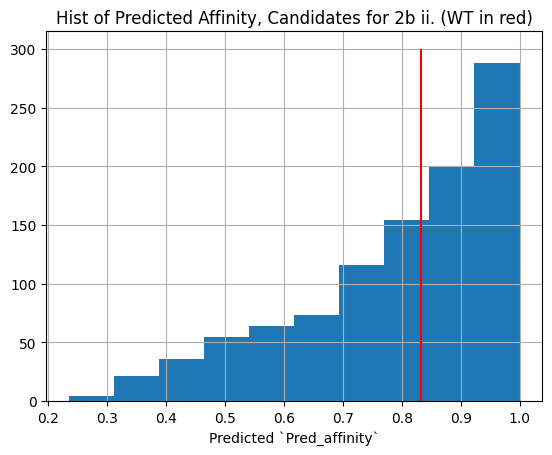

In [24]:
path = f'{DATA_PATH}/max_distance.parquet'
bii_seqs = pd.read_parquet(path).drop_duplicates()
bii_seqs = bii_seqs[bii_seqs['y_hat'] < 1]
print("Candidate count Max Distance:", bii_seqs.shape[0])
ax = bii_seqs['y_hat'].hist()
ax.vlines(wt_affinity, ymax=300, ymin=0, color='red')  # type: ignore 
ax.set_title('Hist of Predicted Affinity, Candidates for Max Distance. (WT in red)')
ax.set_xlabel("Predicted `Pred_affinity`")

<AxesSubplot: >

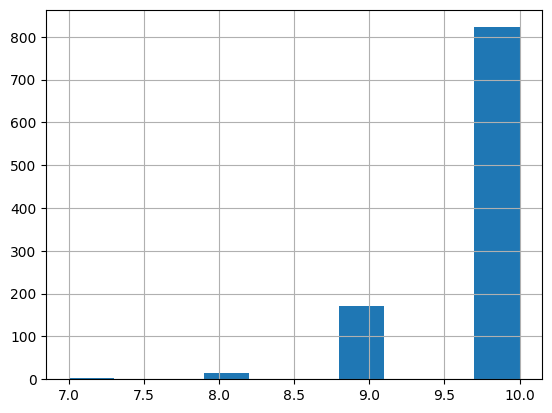

In [26]:
ax.set_title('Hist of Mutation Counts, Candidates for 2b ii. (WT in red)')
mutation_counts = bii_seqs[feature_cols].apply(lambda s: (s!=wt_seq).sum(), axis=1)
mutation_counts.hist()

## Maximize Information Content

Here, there are a couple schools of thought one could follow, explore or exploit:

### Exploit

For this exercise I'll follow the exploit model in the code below.

If we were in the later stages of developing some practical drug, exploitation might make sense. As such, I'd focus on the most promising candidates and do fairly limited exploration around them to build up a solid ground truth.

Procedurally, I start with N of the best mutants proposed in the Max Affinity taks and do a full k=1 mutational scan around them. A k=1 mutational scan is 35 * 20 = 700 mutants. If our budget is 100k sequences for the next round of experiments, then we could do an k=1 scan around N=~140 of these high expected affinity mutants.

### Explore

If more foundational research is preferred (maybe we have more time, more uncertainty about our models), the above criteria could be modified to be more explorative by increasing the distance of the mutational scan (k > 1) for smaller N. We'd select only a few high model-predicted affinity candidates and assay a mutational scan similar to Engelhart's (k <= 3).

### Uncertainty-quantification

Probably the most precise approach to solving this problem the way it is worded would be to train a model with some notion of uncertainty (e.g. Gaussian process, or an ensemble/bootstrap), and do a similar MCMC exploration where the acceptance criteria is based on prediction variance. Thus we'd explore the _variance_ of predicted fitness landscape, (the "uncertainty of fitness" landscape). 

Given Li et al. got best performance from an ensemble, this would be a great step for future work, but is a bit too involved for the purposes of this exercise.

In [9]:
path = f'{DATA_PATH}/max_affinity.parquet'
bi_seqs = pd.read_parquet(path).drop_duplicates()
bi_seqs = bi_seqs[bi_seqs['y_hat'] < 1]

N = 140
starting_sequences = bi_seqs.sort_values('y_hat').iloc[:N]

def scan_sequence(seq: pd.Series):
    """
    Do a k=1 mutational scan of a sequence
    """
    seqs = []
    for i in range(len(seq)):
        for aa in AMINO_ACIDS:
            new_seq = seq.copy()
            new_seq.iloc[i] = aa
            seqs.append(new_seq)
    return pd.concat(seqs, axis=1).T

s = starting_sequences[feature_cols].apply(scan_sequence, axis=1)
full_scan = pd.concat(s.values)
full_scan.to_parquet(f"{DATA_PATH}/max_informative.parquet")